In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as units
import numpy as np
import os
from bokeh.plotting import *
output_notebook()
%load_ext autoreload
%autoreload 2
from getGaiaData import GaiaClusterMembers

Loading BokehJS ...

In [2]:
# read in my OC file and see if I can use that to define the input values
# https://github.com/ageller/compileOCs/blob/master/OCcompiled_clean.csv
clusterName ='NGC_2682' 
#clusterName = 'NGC_188'
#clusterName ='NGC_6819'
#clusterName ='M_35' 
#clusterName ='NGC_7789'
#clusterName = 'NGC_2516' 
#clusterName = 'NGC_3532' #Either a very big cluster or the cluster is very small and ontop of field stars
#clusterName = 'NGC_2506' 
#clusterName = 'M_37' 
#clusterName = 'NGC_6811' 
#clusterName = 'NGC_6791' 
#clusterName = 'NGC_6866'

OCdf = pd.read_csv('OCcompiled_clean_v2.csv')
row = OCdf.loc[OCdf['ID'] == clusterName].iloc[0]

# get the cluster center
center = SkyCoord(row['RA[hr]'], row['Dec[deg]'], unit=(units.hourangle, units.degree))
center.ra.to(units.degree).value
#calculate the distance modulus and error
dmod = 5.*np.log10(row['dist[pc]']) - 5.
err_dmod = (5.*1./np.log(10.)*(1./row['dist[pc]']))*row['err_dist[pc]'] # error propagation
# estimate the cluster tidal radius 
# equation from Binney and Tremaine for Jacoby Radius (8.91)
# want this in degrees
Mg = 1.5*10**12 #*units.solMass #this probably could use verification and a reference
rt = row['rgc[pc]']*(row['mass[Msun]']/(3.*Mg))**(1./3.)
rtfac = 2.
radius = rtfac*np.arctan2(rt, row['dist[pc]'])*180./np.pi
# Note: many clusters won't have Av (and other values)
# for Av, I can get a value from a model, or just use 0

Retrieving Gaia data ... 
INFO: Query finished. [astroquery.utils.tap.core]
Finding radial-velocity members ... 
Finding parallax members ... 
finding proper-motion members ...


/Users/annachilds/opt/anaconda3/envs/BASE9/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/annachilds/opt/anaconda3/envs/BASE9/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


combining memberships ...
plotting CMD ...
done.
Saving data to file NGC_2682_dir/NGC_2682_Gaia_data.ecsv ... 


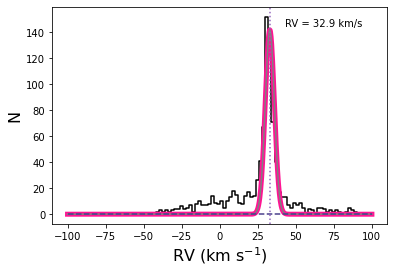

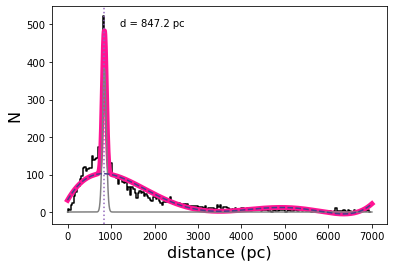

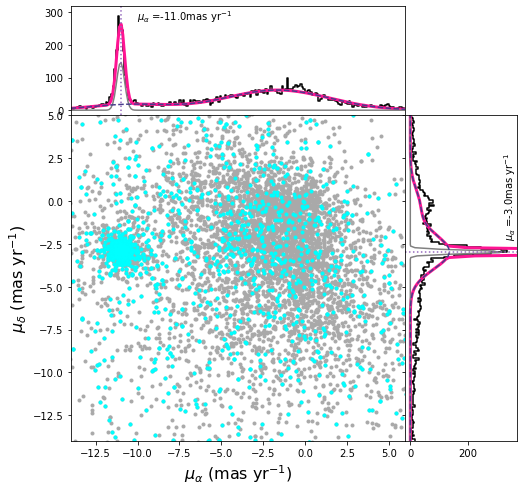

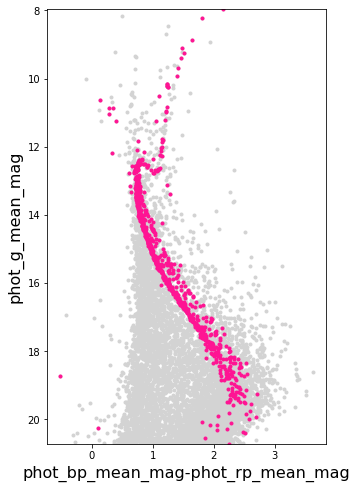

In [3]:
cluster = GaiaClusterMembers(center.ra.to(units.degree).value, center.dec.to(units.degree).value, radius)
pwd = clusterName+'_dir/'
cluster.verbose = 1
try:
    os.makedirs(pwd+'plots')
    os.makedirs(pwd)
except:
    next
cluster.photOutputFileName = pwd + clusterName + '.phot'
cluster.yamlOutputFileName = pwd + 'base9.yaml'
cluster.yamlTemplateFileName = 'template_base9.yaml'
cluster.yamlInputDict = {
    'photFile' : pwd + clusterName + '.phot',
    'outputFileBase' : pwd,
    'modelDirectory' : '/projects/p31721/BASE9/base-models/',
    'msRgbModel' : 5,
    'Fe_H' : [row['[Fe/H]'], row['[Fe/H]'], np.max([row['err_[Fe/H]'], 0.3])],
    'Av' : [row['Av[mag]'], row['Av[mag]'], np.max([row['err_Av[mag]'], 0.3])],
    'Y' : [0.29, 0.29, 0.0], # keep the defaults
    'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
    'logAge' : [np.log10(row['age[Myr]']*10**6), np.log10(row['age[Myr]']*10**6), np.inf],
    'distMod' : [dmod, dmod, np.max([err_dmod, 1.0])],
}
cluster.plotNameRoot = pwd+'/plots/'
cluster.runAll(clusterName)
cluster.saveDataToFile(pwd+clusterName+'_Gaia_data.ecsv')

In [4]:
layout = cluster.createInteractive(mag = 'phot_g_mean_mag', color1 = 'phot_bp_mean_mag', color2 = 'phot_rp_mean_mag', xrng = [-.5,4], yrng = [22,9])
def bkapp(doc):
    doc.add_root(layout)
show(bkapp)

generating phot file ...
generating yaml file ...
Files saved :  NGC_2682_dir/NGC_2682.phot NGC_2682_dir/base9.yaml


In [ ]:
cluster.readDataFromFile(clusterName+'_Gaia_data.ecsv')
cluster.data